# Project 4: Road Finding

by Alex, Lorn, and Ted

## Hypothesis

It is possible to extract road networks from satellite imagery with enough clarity to distinguish them from non-road features.

## Data

Images and rasterized road segments within them in tiles over the state of Massechusetts at 1m resolution. A 0.5m DEM of Massechusetts. A global building footprint dataset from Microsoft. 

### Initial Visuals


In [15]:
from pathlib import Path
from itertools import islice

ROADS_DIR = Path("data/roads/")

for road_dir in ROADS_DIR.iterdir():
    if road_dir.is_dir():
        n = sum(1 for f in road_dir.iterdir() if f.is_file())
        print(road_dir.name, n)

train 1108
train_labels 1108
val 14
test_labels 49
test 49
val_labels 14


In [16]:
print("Image Files")
for item in islice(Path(ROADS_DIR / "train").iterdir(), 10):
    print(item.name)
print("\nLabel Files")
for item in islice(Path(ROADS_DIR / "train_labels").iterdir(), 10):
    print(item.name)

Image Files
17128945_15.tiff
26429275_15.tiff
22228930_15.tiff
20128900_15.tiff
22529395_15.tiff
20578900_15.tiff
24929230_15.tiff
11278945_15.tiff
27028705_15.tiff
24028810_15.tiff

Label Files
24478810_15.tif
11128855_15.tif
22679080_15.tif
11278660_15.tif
17128930_15.tif
24778825_15.tif
17578780_15.tif
15628855_15.tif
10528780_15.tif
17428945_15.tif


/home/lorn/Code/road-finding/.venv/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


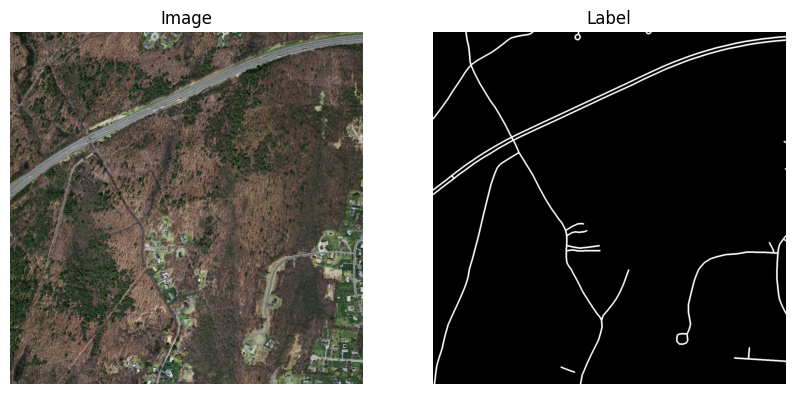

In [17]:
import rasterio
import matplotlib.pyplot as plt

img   = rasterio.open(ROADS_DIR/"test"/"10378780_15.tiff").read()
label = rasterio.open(ROADS_DIR/"test_labels"/"10378780_15.tif").read(1)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(label, cmap="gray")
plt.title("Label")
plt.axis("off")

plt.show()

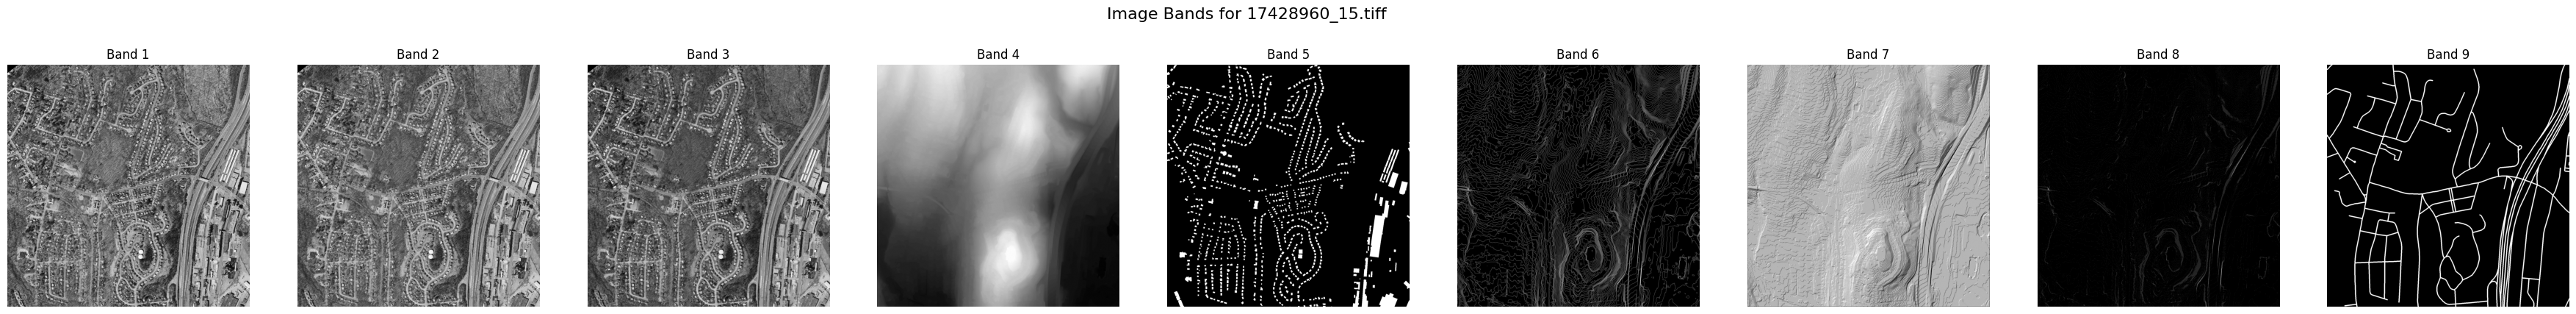

In [49]:
path = ROADS_DIR/"test"/"10378780_15.tiff"
path = Path("data/roads_all_final/train/17428960_15.tiff")
with rasterio.open(path) as src:
    img = src.read()   # shape: (bands, H, W)
    transform = src.transform
    width = src.width
    height = src.height

    # Pixel center indices
    cx = width  / 2
    cy = height / 2

    # Convert pixel center → map coordinates
    center_x, center_y = transform * (cx, cy)

bands, H, W = img.shape

plt.figure(figsize=(5 * bands, 5))
plt.suptitle(f"Image Bands for {path.name}", fontsize=16)
for i in range(bands):
    plt.subplot(1, bands, i+1)
    plt.imshow(img[i], cmap="gray")
    plt.title(f"Band {i+1}")
    plt.axis("off")

plt.show()

In [50]:
from pathlib import Path
import rasterio
import numpy as np
from tqdm import tqdm

ROOT = Path("data/roads_all_final")   # your full final dataset
EXPECTED_BANDS = 9                    # RGB(3) + DEM + Buildings + 3 Terrain + Label
EXPECTED_SIZE = (1500, 1500)

errors = []

for split in ["train", "val", "test"]:
    print(f"\n=== Checking {split} split ===")
    
    for tif in tqdm(sorted((ROOT / split).glob("*.tif")) + 
                    sorted((ROOT / split).glob("*.tiff")),
                    desc=f"{split}"):
        
        try:
            with rasterio.open(tif) as src:
                # ----------------------
                # Band count
                # ----------------------
                if src.count != EXPECTED_BANDS:
                    errors.append((tif, f"Wrong number of bands: {src.count}"))
                
                # ----------------------
                # Size
                # ----------------------
                if (src.height, src.width) != EXPECTED_SIZE:
                    errors.append((tif, "Wrong raster dimensions"))
                
                # ----------------------
                # Check DEM for NaNs
                # Band 4 is DEM
                # ----------------------
                dem = src.read(4)
                if np.isnan(dem).any():
                    errors.append((tif, "DEM contains NaNs"))
                
                # ----------------------
                # Check label band (band 9)
                # ----------------------
                label = src.read(9)
                uniq = np.unique(label)
                
                # Acceptable values: {0,1} or {0,255}
                if not (
                    set(uniq).issubset({0,1}) or
                    set(uniq).issubset({0,255})
                ):
                    errors.append((tif, f"Label has unexpected values {uniq[:10]}"))
                
                # ----------------------
                # Check alignment (transform same as original)
                # ----------------------
                if src.transform[0] != 1 or abs(src.transform[4] + 1) > 1e-6:
                    errors.append((tif, "Transform does not match expected 1m grid"))

        except Exception as e:
            errors.append((tif, f"Read error: {e}"))

# ---------------------------
# Summary
# ---------------------------

print("\n\n=== SUMMARY ===")
if not errors:
    print("✔ All files look good! Every band present, aligned, correct type + resolution.")
else:
    print(f"⚠ Found {len(errors)} issues:")
    for tif, msg in errors[:30]:
        print(f"- {tif}: {msg}")
    if len(errors) > 30:
        print(f"... and {len(errors) - 30} more.")


=== Checking train split ===


train: 100%|██████████| 1108/1108 [04:32<00:00,  4.07it/s]



=== Checking val split ===


val: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]



=== Checking test split ===


test: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]



=== SUMMARY ===
⚠ Found 911 issues:
- data/roads_all_final/train/15628825_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628840_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628855_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628870_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628885_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628900_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628915_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628930_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628945_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15628960_15.tiff: Transform does not match expected 1m grid
- data/roads_all_final/train/15778825_15.tiff: Transform does not match 

In [51]:
import rasterio
src = rasterio.open("data/roads_all_final/train/15628825_15.tiff")
print(src.transform)

| 1.00, 0.00, 155486.44|
| 0.00,-1.00, 883271.03|
| 0.00, 0.00, 1.00|


In [52]:

import rasterio
src = rasterio.open("data/roads_all_final/train/15778945_15.tiff")
print(src.transform)

| 1.00, 0.00, 156986.44|
| 0.00,-1.00, 895271.02|
| 0.00, 0.00, 1.00|


In [19]:
import geopandas as gpd
from shapely.geometry import box
import folium

DATA_DIR = Path("data/roads")  

records = []

for tif in DATA_DIR.rglob("*.tiff"):
    with rasterio.open(tif) as src:
        if not src.crs:
            continue
        
        left, bottom, right, top = src.bounds
        geom = box(left, bottom, right, top)

        records.append({
            "path": str(tif),
            "geometry": geom
        })

gdf = gpd.GeoDataFrame(records, crs="EPSG:26986")  
gdf_ll = gdf.to_crs("EPSG:4326")


center = [42.25, -71.8]

m = folium.Map(location=center, zoom_start=9, tiles="cartodb positron")

for _, row in gdf_ll.iterrows():
    geojson = folium.GeoJson(row["geometry"])
    geojson.add_to(m)

m

In [20]:
from pathlib import Path
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

ROADS_DIR = Path("data/roads")
DEM_PATH = Path("data/dem/Lidar_Elevation_2013to2021.jp2")

OUT_ROOT = Path("data/roads_dem")
OUT_ROOT.mkdir(exist_ok=True)

splits = ["train", "val", "test"]

with rasterio.open(DEM_PATH) as dem_src:
    dem_crs = dem_src.crs
    dem_transform = dem_src.transform

for split in splits:
    in_dir = ROADS_DIR / split
    out_dir = OUT_ROOT / split
    out_dir.mkdir(parents=True, exist_ok=True)

    for tif in sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff")):
        with rasterio.open(tif) as src:
            rgb = src.read()                  # (3, H, W)
            transform = src.transform
            crs = src.crs
            height, width = src.height, src.width
            profile = src.profile

        # Allocate DEM array matching the RGB tile size
        dem_tile = np.zeros((height, width), dtype=np.float32)

        # Reproject DEM → tile CRS → tile resolution → tile footprint
        with rasterio.open(DEM_PATH) as dem_src:
            reproject(
                source=rasterio.band(dem_src, 1),
                destination=dem_tile,
                src_transform=dem_src.transform,
                src_crs=dem_src.crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=Resampling.bilinear
            )

        # Stack RGB + DEM
        stacked = np.vstack([rgb.astype(np.float32),
                             dem_tile[np.newaxis, ...]])

        # Update profile for 4 bands
        profile.update(count=4, dtype="float32")

        out_path = out_dir / tif.name
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)

        print("Wrote:", out_path)

Wrote: data/roads_dem/train/10078660_15.tiff


Wrote: data/roads_dem/train/10078675_15.tiff
Wrote: data/roads_dem/train/10078690_15.tiff
Wrote: data/roads_dem/train/10078705_15.tiff
Wrote: data/roads_dem/train/10078720_15.tiff
Wrote: data/roads_dem/train/10078735_15.tiff
Wrote: data/roads_dem/train/10078750_15.tiff
Wrote: data/roads_dem/train/10228660_15.tiff
Wrote: data/roads_dem/train/10228675_15.tiff
Wrote: data/roads_dem/train/10228705_15.tiff
Wrote: data/roads_dem/train/10228720_15.tiff
Wrote: data/roads_dem/train/10228735_15.tiff
Wrote: data/roads_dem/train/10228750_15.tiff
Wrote: data/roads_dem/train/10228765_15.tiff
Wrote: data/roads_dem/train/10228780_15.tiff
Wrote: data/roads_dem/train/10228795_15.tiff
Wrote: data/roads_dem/train/10378660_15.tiff
Wrote: data/roads_dem/train/10378675_15.tiff
Wrote: data/roads_dem/train/10378690_15.tiff
Wrote: data/roads_dem/train/10378705_15.tiff
Wrote: data/roads_dem/train/10378720_15.tiff
Wrote: data/roads_dem/train/10378735_15.tiff
Wrote: data/roads_dem/train/10378750_15.tiff
Wrote: dat

KeyboardInterrupt: 

In [ ]:
%reset -f

from pystac_client import Client
import planetary_computer as pc

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace
)

buildings_collection = catalog.get_collection("ms-buildings")

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import pyproj
from shapely.ops import transform as shapely_transform
import pandas as pd

def fetch_buildings_for_tile(bounds_26986):
    """
    bounds_26986 = (minx, miny, maxx, maxy)
    Returns: GeoDataFrame of building polygons in EPSG:26986
    """

    # Convert tile bounds (26986) → WGS84
    proj_26986_to_4326 = pyproj.Transformer.from_crs(26986, 4326, always_xy=True).transform
    polygon_4326 = shapely_transform(proj_26986_to_4326, box(*bounds_26986))

    # ✔ Correct: use catalog.search(), NOT collection.search()
    search = catalog.search(
        collections=["ms-buildings"],
        intersects=polygon_4326,
        query={"msbuildings:processing-date": {"gte": "2023-04-25"}},
    )

    items = list(search.items())
    if not items:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:26986")

    gdfs = []
    for item in items:
        asset_href = pc.sign(item.assets["data"].href)
        gdf = gpd.read_parquet(asset_href)
        gdfs.append(gdf)

    # Combine, convert CRS
    buildings = gpd.GeoDataFrame(pd.concat(gdfs), crs="EPSG:4326")
    buildings = buildings.to_crs(26986)

    return buildings

from rasterio.features import rasterize

def rasterize_buildings(polygons_gdf, height, width, transform):
    shapes = [(geom, 1) for geom in polygons_gdf.geometry if geom is not None]
    mask = rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )
    return mask

from tqdm import tqdm
from pathlib import Path
import rasterio
import numpy as np

ROADS_DIR  = Path("data/roads_dem")   # ← where your RGB+DEM tiles now live
OUT_DIR    = Path("data/roads_buildings")
OUT_DIR.mkdir(exist_ok=True)

splits = ["train", "val", "test"]

for split in splits:
    in_dir  = ROADS_DIR / split
    out_dir = OUT_DIR / split
    out_dir.mkdir(parents=True, exist_ok=True)

    tiles = sorted(in_dir.glob("*.tiff"))

    for tif in tqdm(tiles, desc=f"{split} tiles"):

        out_path = out_dir / tif.name
        if out_path.exists():
            continue

        with rasterio.open(tif) as src:
            data = src.read()    # (4, H, W): RGB + DEM
            tile_transform = src.transform
            bounds = src.bounds
            crs = src.crs
            height, width = src.height, src.width
            profile = src.profile

        # 1. Fetch building polygons for the tile bbox
        buildings = fetch_buildings_for_tile((bounds.left, bounds.bottom, bounds.right, bounds.top))

        # 2. Rasterize them into a building mask
        building_mask = rasterize_buildings(buildings, height, width, tile_transform).astype(np.uint8)

        # 3. Stack mask as new band
        stacked = np.vstack([data.astype(np.float32), 
                             building_mask[np.newaxis,...].astype(np.float32)])

        profile.update(count=5, dtype="float32")

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)

train tiles:  42%|████▏     | 465/1108 [01:23<01:56,  5.54it/s] 


KeyboardInterrupt: 

[2025-12-01T01:22:54Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:22:54Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:22:55Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:22:55Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:22:55Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:22:55Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:22:55Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:22:55Z WARN  delta_kernel::engine::default::json] read_json r

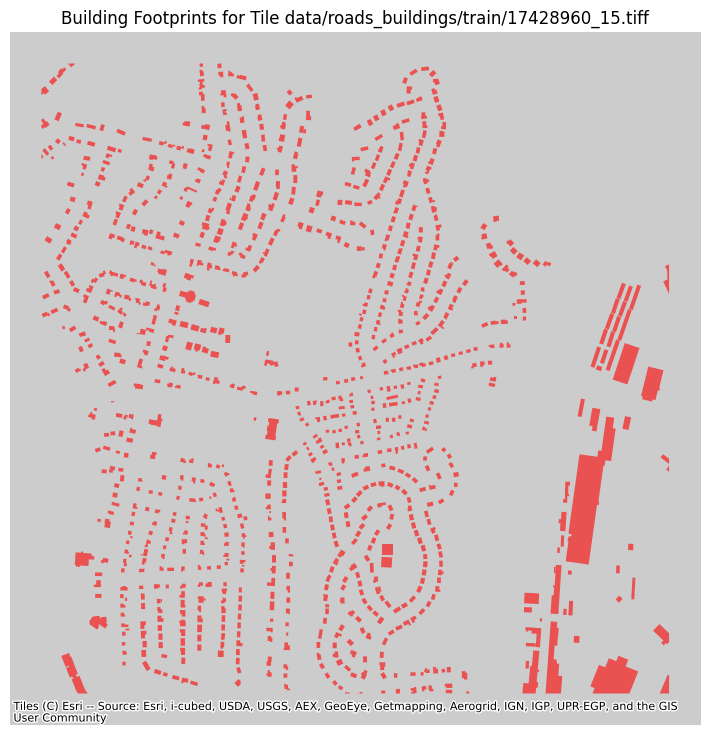

In [34]:
import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely.ops import transform as shapely_transform
import pyproj
import planetary_computer
import pystac_client
import deltalake
import mercantile
import contextily as ctx
import matplotlib.pyplot as plt

# ---------------------------
# 1. Pick one of your actual tiles
# ---------------------------

example_tile = "data/roads_buildings/train/17428960_15.tiff"

with rasterio.open(example_tile) as src:
    bounds_26986 = src.bounds
    crs_tile = src.crs

# Convert to WGS84
proj_to_wgs84 = pyproj.Transformer.from_crs(26986, 4326, always_xy=True).transform
bbox_wgs84_geom = shapely_transform(proj_to_wgs84, box(*bounds_26986))
bbox_wgs84 = box(*bbox_wgs84_geom.bounds)

# ---------------------------
# 2. Connect to Planetary Computer + Delta table
# ---------------------------

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")
asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}

table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

# ---------------------------
# 3. Determine quadkeys at zoom level 9
# ---------------------------

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*bbox_wgs84.bounds, zooms=9)
]

# ---------------------------
# 4. Load parquet files for U.S. footprints matching quadkeys
# ---------------------------

uris = table.file_uris([
    ("RegionName", "=", "UnitedStates"),
    ("quadkey", "in", quadkeys),
])

df = pd.concat([
    gpd.read_parquet(uri, storage_options=storage_options)
    for uri in uris
])

# ---------------------------
# 5. Clip buildings to the tile bounding box
# ---------------------------

buildings_4326 = df.to_crs(4326).clip(bbox_wgs84)
buildings_26986 = buildings_4326.to_crs(26986)

# ---------------------------
# 6. Plot buildings on basemap
# ---------------------------

fig, ax = plt.subplots(figsize=(9, 9))
buildings_4326.plot(ax=ax, color="red", alpha=0.6, linewidth=0)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=17)
ax.set_title("Building Footprints for Tile {}".format(example_tile))
ax.set_axis_off()

plt.show()

In [35]:
from pathlib import Path
import rasterio
import rasterio.features
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
from shapely.ops import transform as shapely_transform
import pyproj
import planetary_computer
import pystac_client
import deltalake
import mercantile
from tqdm import tqdm

# ============================================================
# 1. CONNECT TO PLANETARY COMPUTER + LOAD DELTA TABLE (ONCE)
# ============================================================

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")
asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}

table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

# cache quadkeys → df
quadkey_cache = {}

# CRS conversions
to_wgs84 = pyproj.Transformer.from_crs(26986, 4326, always_xy=True).transform
to_26986 = pyproj.Transformer.from_crs(4326, 26986, always_xy=True).transform


# ============================================================
# 2. LOAD BUILDINGS FOR ONE TILE (CACHED BY QUADKEY)
# ============================================================

def load_buildings_for_tile(tile_bounds):
    """ tile_bounds = (minx, miny, maxx, maxy) in EPSG:26986 """
    
    # Convert to WGS84 bounding box for Planetary Computer
    bbox_4326_geom = shapely_transform(to_wgs84, box(*tile_bounds))
    bbox_4326 = box(*bbox_4326_geom.bounds)

    # Find quadkeys at zoom=9
    quadkeys = [
        int(mercantile.quadkey(t))
        for t in mercantile.tiles(*bbox_4326.bounds, zooms=9)
    ]

    # Load parquet files for each quadkey (cached)
    gdfs = []
    for qk in quadkeys:
        if qk not in quadkey_cache:
            uris = table.file_uris([
                ("RegionName", "=", "UnitedStates"),
                ("quadkey", "=", qk),
            ])
            if uris:
                quadkey_cache[qk] = pd.concat([
                    gpd.read_parquet(uri, storage_options=storage_options)
                    for uri in uris
                ])
            else:
                quadkey_cache[qk] = gpd.GeoDataFrame(geometry=[])
        gdfs.append(quadkey_cache[qk])

    df = pd.concat(gdfs)
    if df.empty:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:26986")

    # Clip in WGS84
    buildings_4326 = df.to_crs(4326).clip(bbox_4326)

    # Convert back into EPSG:26986 (tile CRS)
    buildings_26986 = buildings_4326.to_crs(26986)

    return buildings_26986


# ============================================================
# 3. RASTERIZE BUILDING FOOTPRINTS
# ============================================================

def rasterize_buildings(buildings_gdf, height, width, transform):
    """ Return a 0/1 building mask """
    if buildings_gdf.empty:
        return np.zeros((height, width), dtype=np.uint8)

    shapes = [(geom, 1) for geom in buildings_gdf.geometry]
    mask = rasterio.features.rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )
    return mask


# ============================================================
# 4. MAIN LOOP — ADD BUILDING MASK AS BAND 5
# ============================================================

INPUT_DIR = Path("data/roads_dem")   # your RGB + DEM tiles
OUT_DIR = Path("data/roads_dem_buildings")
OUT_DIR.mkdir(exist_ok=True, parents=True)

splits = ["train", "val", "test"]

for split in splits:
    print(f"\nProcessing split: {split}")
    in_dir = INPUT_DIR / split
    out_dir = OUT_DIR / split
    out_dir.mkdir(exist_ok=True)

    tiles = sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff"))

    for tif in tqdm(tiles, desc=f"{split} tiles"):

        out_path = out_dir / tif.name
        if out_path.exists():
            continue

        # Load RGB + DEM tile
        with rasterio.open(tif) as src:
            data = src.read()   # (4, H, W)
            transform = src.transform
            bounds = src.bounds
            height, width = src.height, src.width
            profile = src.profile

        # 1. Load building polygons
        buildings = load_buildings_for_tile((bounds.left, bounds.bottom,
                                             bounds.right, bounds.top))

        # 2. Rasterize to mask
        building_mask = rasterize_buildings(buildings, height, width, transform)

        # 3. Add as 5th band
        stacked = np.vstack([
            data.astype(np.float32), 
            building_mask[np.newaxis, ...].astype(np.float32)
        ])

        # Update profile
        profile.update(count=5, dtype="float32")

        # 4. Write final 5-band GeoTIFF
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)

[2025-12-01T01:27:39Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:27:39Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:27:39Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:27:40Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:27:40Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:27:40Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:27:40Z WARN  delta_kernel::engine::default::json] read_json receiver end of channel dropped before sending completed
[2025-12-01T01:27:40Z WARN  delta_kernel::engine::default::json] read_json r


Processing split: train


train tiles: 100%|██████████| 1108/1108 [05:57<00:00,  3.10it/s]



Processing split: val


val tiles: 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]



Processing split: test


test tiles: 100%|██████████| 49/49 [00:12<00:00,  4.05it/s]


In [39]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import rasterio
from rasterio.io import MemoryFile
from osgeo import gdal

gdal.UseExceptions()

# --------------------------------------------------------
# CONFIG
# --------------------------------------------------------

INPUT_DIR = Path("data/roads_dem_buildings")   # input: 5-band tiles
OUT_DIR   = Path("data/roads_dem_buildings_terrain")
OUT_DIR.mkdir(exist_ok=True, parents=True)

splits = ["train", "val", "test"]

# --------------------------------------------------------
# Helper: run gdaldem into /vsimem/ and return array
# --------------------------------------------------------

def gdaldem_process(src_array, transform, crs, operation, **kwargs):
    """Run gdaldem on a NumPy DEM tile in memory and return a single array."""
    H, W = src_array.shape

    # Create in-memory GDAL dataset for the DEM tile
    driver = gdal.GetDriverByName("MEM")
    ds = driver.Create("", W, H, 1, gdal.GDT_Float32)
    ds.GetRasterBand(1).WriteArray(src_array)
    ds.SetGeoTransform((
        transform.c, transform.a, transform.b,
        transform.f, transform.d, transform.e
    ))
    ds.SetProjection(crs.to_wkt())

    # Output to GDAL's RAM filesystem
    out_path = "/vsimem/temp_dem.tif"
    gdal.DEMProcessing(out_path, ds, operation, **kwargs)

    # Read output via rasterio
    with rasterio.open(out_path) as tmp:
        arr = tmp.read(1)

    # Clean RAM
    gdal.Unlink(out_path)

    return arr

# --------------------------------------------------------
# Helper: compute slope, hillshade, roughness
# --------------------------------------------------------

def compute_terrain_layers(dem_tile, transform, crs):
    # 1) Slope (degrees) → scale by 10 → uint16
    slope = gdaldem_process(
        dem_tile, transform, crs,
        "slope",
        computeEdges=True
    )
    slope16 = np.clip(slope * 10, 0, 65535).astype("uint16")

    # 2) Hillshade (0–255)
    hillshade = gdaldem_process(
        dem_tile, transform, crs,
        "hillshade",
        azimuth=315, altitude=45,
        computeEdges=True
    ).astype("uint8")

    # 3) Roughness (0–255)
    roughness = gdaldem_process(
        dem_tile, transform, crs,
        "roughness",
        computeEdges=True
    ).astype("uint8")

    return slope16, hillshade, roughness

# --------------------------------------------------------
# MAIN LOOP
# --------------------------------------------------------

for split in splits:
    in_dir  = INPUT_DIR / split
    out_dir = OUT_DIR / split
    out_dir.mkdir(parents=True, exist_ok=True)

    tiles = sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff"))
    print(f"\nProcessing {split}: {len(tiles)} tiles")

    for tif in tqdm(tiles, desc=f"{split}", unit="tile"):
        out_path = out_dir / tif.name
        if out_path.exists():
            continue

        # --------------------------------------------------
        # Load the 5-band tile: RGB, DEM, building mask
        # --------------------------------------------------
        with rasterio.open(tif) as src:
            data = src.read()       # shape: (5, H, W)
            transform = src.transform
            crs = src.crs
            H, W = src.height, src.width
            profile = src.profile

        rgb = data[:3]             # uint8
        dem_tile = data[3]         # float32
        building_mask = data[4]    # float32 or uint8, depending how you saved it

        # --------------------------------------------------
        # Compute terrain attributes
        # --------------------------------------------------
        slope16, hillshade8, roughness8 = compute_terrain_layers(
            dem_tile, transform, crs
        )

        # --------------------------------------------------
        # Stack final bands
        # --------------------------------------------------
        stacked = np.concatenate([
            rgb.astype("uint8"),               # 3 uint8
            dem_tile[np.newaxis, ...],         # 1 float32
            building_mask[np.newaxis, ...],    # 1 uint8/float32
            slope16[np.newaxis, ...],          # 1 uint16
            hillshade8[np.newaxis, ...],       # 1 uint8
            roughness8[np.newaxis, ...]        # 1 uint8
        ], axis=0)

        # --------------------------------------------------
        # Update metadata
        # --------------------------------------------------
        profile.update(
            count=stacked.shape[0],
            compress="lzw",
            tiled=True,
            blockxsize=512,
            blockysize=512,
            predictor=2
        )

        # --------------------------------------------------
        # Write compressed, tiled GeoTIFF
        # --------------------------------------------------
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)

ModuleNotFoundError: No module named '_gdal'

In [42]:
from pathlib import Path
import subprocess
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
from tqdm import tqdm

# ==========================================
# SETTINGS
# ==========================================

ROADS_DIR = Path("data/roads_dem_buildings")            # original RGB tiles
DEM_PATH   = Path("data/dem/Lidar_Elevation_2013to2021.jp2")
OUT_DIR    = Path("data/roads_final")     # RGB + DEM + terrain
OUT_DIR.mkdir(exist_ok=True, parents=True)

splits = ["train", "val", "test"]

# ==========================================
# Helper: run GDAL terrain operation in-memory
# ==========================================

def gdaldem_array(mode, src_path, **kwargs):
    """
    Runs gdaldem <mode> on src_path and returns the result as a NumPy array.
    Uses /vsimem/ to avoid writing temp files.
    """
    out_path = "/vsimem/temp.tif"

    cmd = ["gdaldem", mode, str(src_path), out_path]
    for k, v in kwargs.items():
        if v is True:
            cmd.append(f"-{k}")
        else:
            cmd += [f"-{k}", str(v)]

    subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    arr = rasterio.open(out_path).read(1)
    return arr


# ==========================================
# STEP 1: Pre-open DEM (saves time)
# ==========================================

with rasterio.open(DEM_PATH) as dem_src:
    dem_crs = dem_src.crs
    dem_transform = dem_src.transform


# ==========================================
# MAIN LOOP
# ==========================================

for split in splits:
    print(f"\n=== Processing {split} ===")

    in_dir  = ROADS_DIR / split
    out_dir = OUT_DIR / split
    out_dir.mkdir(exist_ok=True)

    tiles = sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff"))

    for tif in tqdm(tiles, desc=f"{split} tiles"):

        out_path = out_dir / tif.name
        if out_path.exists():
            continue

        # -------------------------------------------------------
        # Load RGB tile
        # -------------------------------------------------------
        with rasterio.open(tif) as src:
            rgb = src.read()   # (3, H, W), uint8
            transform = src.transform
            crs = src.crs
            height, width = src.height, src.width
            profile = src.profile

        # -------------------------------------------------------
        # Reproject DEM into tile footprint
        # -------------------------------------------------------
        dem_tile = np.zeros((height, width), dtype=np.float32)

        with rasterio.open(DEM_PATH) as dem_src:
            reproject(
                rasterio.band(dem_src, 1),
                dem_tile,
                src_transform=dem_src.transform,
                src_crs=dem_src.crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=Resampling.bilinear
            )

        # Convert DEM to float16 to save space
        dem_tile = dem_tile.astype("float16")

        # -------------------------------------------------------
        # GDAL Terrain Layers
        # -------------------------------------------------------

        # Slope (degrees)
        slope = gdaldem_array("slope", tif, compute_edges=True)
        slope = (slope * 10).astype("uint16")   # store with 0.1° precision

        # Hillshade (NW light)
        hillshade = gdaldem_array("hillshade", tif, az=315, alt=45)
        hillshade = hillshade.astype("uint8")

        # Roughness
        roughness = gdaldem_array("roughness", tif, compute_edges=True)
        roughness = roughness.astype("uint8")

        # -------------------------------------------------------
        # Stack all bands
        # -------------------------------------------------------

        stacked = np.vstack([
            rgb.astype(np.uint8),         # 3 bands
            dem_tile[np.newaxis, ...],    # 1 band (float16)
            slope[np.newaxis, ...],       # 1 band (uint16)
            hillshade[np.newaxis, ...],   # 1 band (uint8)
            roughness[np.newaxis, ...]    # 1 band (uint8)
        ])

        # -------------------------------------------------------
        # Save compressed multi-band GeoTIFF
        # -------------------------------------------------------

        profile.update(
            count = stacked.shape[0],
            dtype = stacked.dtype,  # mixed types ok; rasterio promotes properly
            compress = "lzw",
            predictor = 2,
            tiled = True,
            blockxsize = 512,
            blockysize = 512
        )

        # Write tile
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)


=== Processing train ===


train tiles:   0%|          | 0/1108 [00:00<?, ?it/s]


RasterioIOError: No such file or directory

In [44]:
from pathlib import Path
import subprocess
import rasterio
import numpy as np
from tqdm import tqdm

# ==========================================
# CONFIG
# ==========================================

INPUT_DIR = Path("data/roads_dem_buildings")   # where your 5-band TIFFs live
OUT_DIR   = Path("data/roads_terrain_final")   # final output
OUT_DIR.mkdir(parents=True, exist_ok=True)

splits = ["train", "val", "test"]

# ==========================================
# Helper: run gdaldem on an in-memory DEM
# ==========================================

def gdaldem_array(mode, dem_arr, profile, **kwargs):
    """
    Runs gdaldem <mode> on a DEM array by writing to /vsimem/,
    then returns a numpy array result.
    """
    # Write DEM to vsimem
    src_path = "/vsimem/dem_input.tif"
    with rasterio.open(src_path, "w", **profile) as dst:
        dst.write(dem_arr[np.newaxis, ...])  # write as band 1

    out_path = "/vsimem/dem_out.tif"
    cmd = ["gdaldem", mode, src_path, out_path]

    for k, v in kwargs.items():
        if v is True:
            cmd.append(f"-{k}")
        else:
            cmd += [f"-{k}", str(v)]

    subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)

    # Read output
    out = rasterio.open(out_path).read(1)

    return out


# ==========================================
# MAIN LOOP
# ==========================================

for split in splits:
    print(f"\n=== Processing {split} ===")
    in_dir  = INPUT_DIR / split
    out_dir = OUT_DIR / split
    out_dir.mkdir(parents=True, exist_ok=True)

    tiles = sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff"))

    for tif in tqdm(tiles, desc=f"{split} tiles"):
        out_path = out_dir / tif.name

        if out_path.exists():
            continue

        # --------------------------------------------------
        # Load existing 5-band tile
        # --------------------------------------------------
        with rasterio.open(tif) as src:
            data = src.read()              # shape (5, H, W)
            transform = src.transform
            crs = src.crs
            profile = src.profile
            height, width = src.height, src.width

        rgb = data[:3]                # uint8
        dem = data[3].astype(float)   # ensure float for gdaldem
        bmask = data[4]               # building mask uint8

        # Profile for DEM-only raster
        dem_profile = profile.copy()
        dem_profile.update(
            count=1,
            dtype="float32",
            compress=None,
            tiled=False
        )

        # --------------------------------------------------
        # Terrain features via gdaldem on DEM
        # --------------------------------------------------

        slope = gdaldem_array("slope", dem, dem_profile, compute_edges=True)
        slope = (slope * 10).astype("uint16")   # store with 0.1° precision

        hillshade = gdaldem_array("hillshade", dem, dem_profile, az=315, alt=45)
        hillshade = hillshade.astype("uint8")

        roughness = gdaldem_array("roughness", dem, dem_profile, compute_edges=True)
        roughness = roughness.astype("uint8")

        # --------------------------------------------------
        # Stack everything
        # --------------------------------------------------
        stacked = np.vstack([
            rgb.astype("uint8"),            # 3 bands
            dem.astype("float16")[None],    # DEM as float16
            bmask[None].astype("uint8"),    # buildings
            slope[None],                    # uint16
            hillshade[None],                # uint8
            roughness[None]                 # uint8
        ])

        # --------------------------------------------------
        # Update profile for final multi-band GeoTIFF
        # --------------------------------------------------
        profile.update(
            count = stacked.shape[0],
            compress = "lzw",
            predictor = 2,
            tiled = True,
            blockxsize = 512,
            blockysize = 512
        )

        # --------------------------------------------------
        # Write final output
        # --------------------------------------------------
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)


=== Processing train ===


train tiles:   0%|          | 0/1108 [00:00<?, ?it/s]


CalledProcessError: Command '['gdaldem', 'slope', '/vsimem/dem_input.tif', '/vsimem/dem_out.tif', '-compute_edges']' returned non-zero exit status 1.

In [47]:
from pathlib import Path
import subprocess
import rasterio
import numpy as np
from tqdm import tqdm
import tempfile
import os

# ==========================================
# CONFIG
# ==========================================

INPUT_DIR = Path("data/roads_dem_buildings")   # existing 5-band TIFFs
OUT_DIR   = Path("data/roads_terrain_final")   # final output
OUT_DIR.mkdir(parents=True, exist_ok=True)

splits = ["train", "val", "test"]

# ==========================================
# Helper: run gdaldem using a temp file
# ==========================================

def gdaldem_array(mode, dem_arr, profile, **kwargs):
    """
    Writes dem_arr to a temporary GeoTIFF,
    runs 'gdaldem <mode>' on it,
    and returns the output array.
    """
    # Create temporary filenames
    with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as f_in:
        temp_in = f_in.name
    with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as f_out:
        temp_out = f_out.name

    # Write DEM to disk
    with rasterio.open(temp_in, "w", **profile) as dst:
        dst.write(dem_arr[np.newaxis, ...])

    # Build gdaldem command
    cmd = ["gdaldem", mode, temp_in, temp_out]
    for k, v in kwargs.items():
        if v is True:
            cmd.append(f"-{k}")
        else:
            cmd += [f"-{k}", str(v)]

    # Run gdaldem
    subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)

    # Read output
    out = rasterio.open(temp_out).read(1)

    # Cleanup
    os.remove(temp_in)
    os.remove(temp_out)

    return out


# ==========================================
# MAIN LOOP
# ==========================================

for split in splits:
    print(f"\n=== Processing {split} ===")
    in_dir  = INPUT_DIR / split
    out_dir = OUT_DIR / split
    out_dir.mkdir(parents=True, exist_ok=True)

    tiles = sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff"))

    for tif in tqdm(tiles, desc=f"{split} tiles"):
        out_path = out_dir / tif.name

        if out_path.exists():
            continue

        # --------------------------------------------------
        # Load existing 5-band tile
        # --------------------------------------------------
        with rasterio.open(tif) as src:
            data = src.read()              # (5, H, W)
            transform = src.transform
            crs = src.crs
            profile = src.profile
            height, width = src.height, src.width

        rgb = data[:3].astype("uint8")
        dem = data[3].astype("float32")
        bmask = data[4].astype("uint8")

        # Minimal profile for DEM input to gdaldem
        dem_profile = {
            "driver": "GTiff",
            "height": height,
            "width": width,
            "count": 1,
            "dtype": "float32",
            "transform": transform,
            "crs": crs
        }

        # --------------------------------------------------
        # Terrain products
        # --------------------------------------------------

        slope = gdaldem_array("slope", dem, dem_profile, compute_edges=True)
        slope = (slope * 10).astype("uint16")

        hillshade = gdaldem_array("hillshade", dem, dem_profile, az=315, alt=45)
        hillshade = hillshade.astype("uint8")

        roughness = gdaldem_array("roughness", dem, dem_profile, compute_edges=True)
        roughness = roughness.astype("uint8")

        # --------------------------------------------------
        # Stack final bands
        # --------------------------------------------------

        stacked = np.vstack([
            rgb,
            dem.astype("float16")[None],
            bmask[None],
            slope[None],
            hillshade[None],
            roughness[None]
        ])

        # --------------------------------------------------
        # Save final TIFF (compressed, small)
        # --------------------------------------------------

        profile.update(
            count = stacked.shape[0],
            compress = "lzw",
            predictor = 2,
            tiled = True,
            blockxsize = 512,
            blockysize = 512
        )
        # NOTE: DO NOT set dtype — rasterio handles mixed dtypes internally.

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(stacked)


=== Processing train ===


train tiles: 100%|██████████| 1108/1108 [05:32<00:00,  3.34it/s]



=== Processing val ===


val tiles: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]



=== Processing test ===


test tiles: 100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


In [48]:
from pathlib import Path
import rasterio
import numpy as np
from tqdm import tqdm

# --------------------------------------
# Paths
# --------------------------------------

FINAL_TERRAINS = Path("data/roads_terrain_final")
LABELS_ROOT    = Path("data/roads")
OUT_ROOT       = Path("data/roads_all_final")   # NEW directory
OUT_ROOT.mkdir(parents=True, exist_ok=True)

splits = ["train", "val", "test"]

# --------------------------------------
# Main
# --------------------------------------

for split in splits:
    print(f"\n=== Processing split: {split} ===")

    in_dir  = FINAL_TERRAINS / split
    lbl_dir = LABELS_ROOT / f"{split}_labels"
    out_dir = OUT_ROOT / split
    out_dir.mkdir(parents=True, exist_ok=True)

    tiles = sorted(in_dir.glob("*.tif")) + sorted(in_dir.glob("*.tiff"))

    for tif in tqdm(tiles, desc=f"{split} tiles"):

        out_path = out_dir / tif.name
        if out_path.exists():
            continue

        # ---------------------------
        # Load final terrain features
        # ---------------------------
        with rasterio.open(tif) as src:
            data = src.read()      # shape: (N, H, W)
            profile = src.profile
            height, width = src.height, src.width

        # ---------------------------
        # Find and load label mask
        # ---------------------------
        name_stem = tif.stem   # e.g., 10228690_15
        label_path = lbl_dir / f"{name_stem}.tif"

        if not label_path.exists():
            print(f"WARNING: Missing label: {label_path}")
            continue

        with rasterio.open(label_path) as lbl_src:
            label = lbl_src.read(1)   # 2D array
            # Ensure correct dtype
            label = label.astype("uint8")

            if lbl_src.width != width or lbl_src.height != height:
                raise ValueError(f"Label size mismatch for {tif.name}")

        # ---------------------------
        # Add label as last band
        # ---------------------------
        final_stack = np.vstack([
            data,
            label[np.newaxis, ...]
        ])

        # Update band count
        profile.update(count=final_stack.shape[0])

        # LZW compression recommended for mixed band types
        profile.update(compress="lzw", predictor=2)

        # ---------------------------
        # Write output
        # ---------------------------
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(final_stack)


=== Processing split: train ===


train tiles:   0%|          | 0/1108 [00:00<?, ?it/s]/home/lorn/Code/road-finding/.venv/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
train tiles: 100%|██████████| 1108/1108 [12:24<00:00,  1.49it/s]



=== Processing split: val ===


val tiles: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]



=== Processing split: test ===


test tiles: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]
